## Лабораторная работа №5

Задание: Выделить ягоды

In [18]:
import sys
sys.path.append('../')
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import data
from scipy import ndimage
import matplotlib.pyplot as plt
import segmentation_utils


image = cv.imread('img.jpg')
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_hsv = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

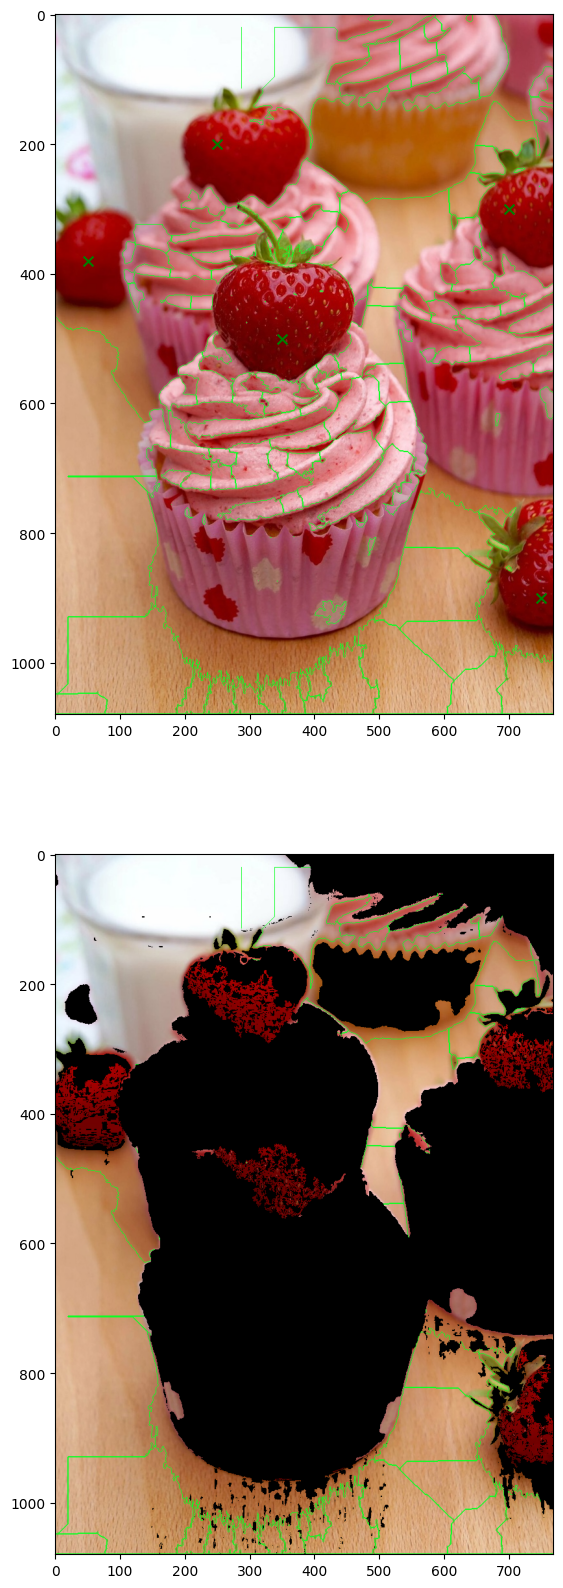

In [23]:
# определяем координаты начальных точек
seeds = [
        (380, 50),
        (200, 250),
        (500, 350),
        (300, 700),
        (900, 750)
    ]
# координаты для графика
x = list(map(lambda x: x[1], seeds))
y = list(map(lambda x: x[0], seeds))
# порог похожести цвета региона
threshold = 86
# находим сегментацию используя метод из segmentation_utils
segmented_region = segmentation_utils.region_growingHSV(image_hsv, seeds, threshold)
# накладываем маску - отображаем только участки попавшие в какой-либо сегмент
result = cv.bitwise_and(image, image, mask=segmented_region)
# отображаем полученное изображение
gs = plt.GridSpec(2, 1)
plt.figure(figsize=(15,20))
plt.subplot(gs[0])
plt.scatter(x, y, marker="x", color="green", s=50)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(gs[1])
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()